# Import and Load

In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from nltk_setup import setup_nltk
setup_nltk()
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from tqdm import tqdm
from nltk.util import ngrams
import osmnx as ox
import geopandas as gpd
import urllib
from googlemaps import Client
import pandas as pd
from time import sleep
import os
from dotenv import load_dotenv
from geopy.geocoders import Nominatim
import csv
import time

NLTK punkt is already downloaded
NLTK averaged_perceptron_tagger is already downloaded
NLTK stopwords is already downloaded


In [166]:
tr_raw = pd.read_csv('train_raw.csv')
te_raw = pd.read_csv('test_raw.csv')

tr_clean = pd.DataFrame()
te_clean = pd.DataFrame()

# Type Setting, Nan values, Simple Engineering

### price, square_meters


In [167]:
print(tr_raw[['y', 'square_meters']].info())
print(tr_raw[['y', 'square_meters']].describe())

print(te_raw[['square_meters']].info())
print(te_raw[['square_meters']].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   y              4500 non-null   int64
 1   square_meters  4500 non-null   int64
dtypes: int64(2)
memory usage: 70.4 KB
None
                 y  square_meters
count  4500.000000    4500.000000
mean   1983.720667      75.248444
std    1302.870057      38.732704
min     450.000000      15.000000
25%    1200.000000      50.000000
50%    1550.000000      65.000000
75%    2400.000000      90.000000
max    9300.000000     260.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2834 entries, 0 to 2833
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   square_meters  2834 non-null   int64
dtypes: int64(1)
memory usage: 22.3 KB
None
       square_meters
count    2834.000000
mean       75.863797
std        39.569486
min        15.00

In [168]:
tr_clean['price'] = tr_raw['y']
tr_clean['square_meters'] = tr_raw['square_meters']

tr_clean['price'] = tr_clean['price'].astype(float)
tr_clean['square_meters'] = tr_clean['square_meters'].astype(float)

te_clean['square_meters'] = te_raw['square_meters']
te_clean['square_meters'] = te_clean['square_meters'].astype(float)

### contract type

In [169]:
print(tr_raw[['contract_type']].info())
print(tr_raw[['contract_type']].describe())
print(tr_raw[['contract_type']].value_counts())
print(te_raw[['contract_type']].info())
print(te_raw[['contract_type']].describe())
print(te_raw[['contract_type']].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   contract_type  4500 non-null   object
dtypes: object(1)
memory usage: 35.3+ KB
None
       contract_type
count           4500
unique             7
top       rent | 4+4
freq            1883
contract_type                  
rent | 4+4                         1883
rent | transitory                  1135
rent                               1122
rent | open                         308
rent | 3+2                           24
rent | students (6 - 36 months)      15
rent | 6+6                           13
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2834 entries, 0 to 2833
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   contract_type  2834 non-null   object
dtypes: object(1)
memory usage: 22.3+ KB


In [170]:
tr_clean['contract_type'] = tr_raw['contract_type']
tr_clean['contract_type'] = tr_clean['contract_type'].fillna('')

contract_type_mapping = {x : i for i, x in enumerate(tr_clean['contract_type'].unique())}

tr_clean['contract_type'] = tr_clean['contract_type'].map(contract_type_mapping)
tr_clean = pd.get_dummies(tr_clean, columns=['contract_type'], dtype=int)

te_clean['contract_type'] = te_raw['contract_type']
te_clean['contract_type'] = te_clean['contract_type'].fillna('')

te_clean['contract_type'] = te_clean['contract_type'].map(contract_type_mapping)
te_clean = pd.get_dummies(te_clean, columns=['contract_type'], dtype=int)

### Availability

In [171]:
print(tr_raw[['availability']].info())
print(tr_raw[['availability']].describe())
print(tr_raw[['availability']].value_counts())
print(te_raw[['availability']].info())
print(te_raw[['availability']].describe())
print(te_raw[['availability']].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   availability  3855 non-null   object
dtypes: object(1)
memory usage: 35.3+ KB
None
       availability
count          3855
unique          189
top       available
freq           3013
availability             
available                    3013
available from 01/05/2024      78
available from 01/04/2024      65
available from 01/06/2024      59
available from 01/07/2024      28
                             ... 
available from 19/06/2024       1
available from 10/07/2023       1
available from 10/07/2024       1
available from 19/03/2024       1
available from 14/03/2024       1
Name: count, Length: 189, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2834 entries, 0 to 2833
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  

In [172]:
def process_availability(df, raw_df):
    df['availability'] = raw_df['availability']
    
    df['availability_year'] = (df['availability']
                         .str.replace('available', '')
                         .str.replace('from', '')
                         .str.strip())
    
    df['availability_year'] = pd.to_datetime(df['availability_year'], format='%d/%m/%Y', errors='coerce')
    
    df['availability_year'] = df['availability_year'].dt.year.fillna(-1).astype(int)
    df['availability_year_not_available'] = df['availability_year'] == -1
    df['availability_year_not_available'] = df['availability_year_not_available'].astype(int)

    unique_years = df['availability_year'].unique()
    unique_years = unique_years[unique_years != -1]  # Exclude the -1 placeholder
    
    for year in unique_years:
        df[f'availability_year_{year}'] = (df['availability_year'] == year).astype(int)
    
    df['availability_instant'] = (df['availability'] == 'available').astype(int)
    
    df = df.drop(columns=['availability', 'availability_year'])
    
    return df

# Process training data
tr_clean = process_availability(tr_clean, tr_raw)

# Process test data  
te_clean = process_availability(te_clean, te_raw)

In [173]:
missing_years_in_test = [2015, 2016, 2020, 2025]
for y in missing_years_in_test:
    te_clean[f'availability_year_{y}'] = 0

### Description

In [114]:
print(tr_raw[['description']].info())
print(te_raw[['description']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  4500 non-null   object
dtypes: object(1)
memory usage: 35.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2834 entries, 0 to 2833
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  2834 non-null   object
dtypes: object(1)
memory usage: 22.3+ KB
None


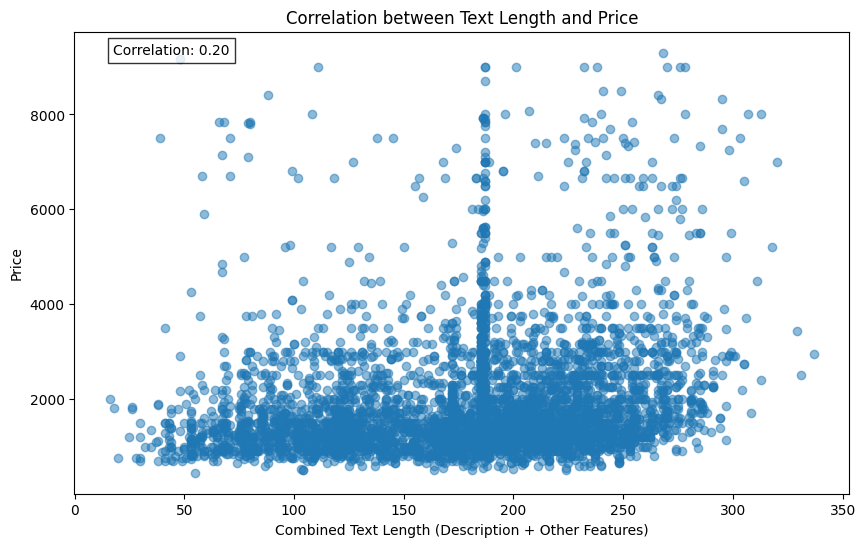

In [180]:
# correlation between description + other feature text length vs price
text_length = tr_raw['description'].str.len() + tr_raw['other_features'].str.len()

plt.figure(figsize=(10, 6))
plt.scatter(text_length, tr_raw['y'], alpha=0.5)
plt.xlabel('Combined Text Length (Description + Other Features)')
plt.ylabel('Price')
plt.title('Correlation between Text Length and Price')

# Add correlation coefficient
correlation = text_length.corr(tr_raw['y'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()


In [115]:
# get an idea of all possible descriptions
tr_raw['description'].iloc[np.random.randint(0, 4501, 20)].values

array(['2 (1 bedroom, 1 other), 1 bathroom, open kitchen',
       '2 (1 bedroom, 1 other), 1 bathroom, kitchen diner',
       '2 (1 bedroom, 1 other), 2 bathrooms, kitchen diner',
       '2 (1 bedroom, 1 other), 1 bathroom',
       '3 (2 bedrooms, 1 other), 2 bathrooms, kitchen diner',
       '2 (1 bedroom, 1 other), 1 bathroom, kitchenette',
       '2 (1 bedroom, 1 other), 1 bathroom, open kitchen',
       '2 (1 bedroom, 1 other), 1 bathroom',
       '3 (2 bedrooms, 1 other), 1 bathroom, kitchen diner',
       '1 bedroom, 1 bathroom',
       '4 (2 bedrooms, 2 others), 3 bathrooms, semi-habitable kitchen',
       '2 (1 bedroom, 1 other), 1 bathroom, kitchen diner',
       '2 (1 bedroom, 1 other), 2 bathrooms, open kitchen',
       '3 (2 bedrooms, 1 other), 2 bathrooms, kitchen diner',
       '3 (2 bedrooms, 1 other), 1 bathroom, kitchen diner',
       '3 (2 bedrooms, 1 other), 1 bathroom',
       '3 (2 bedrooms, 1 other), 2 bathrooms, kitchen diner',
       '3 (2 bedrooms, 1 other), 1 

In [116]:
import re

def extract_room_info(text):
    result = {
        'bedrooms': None,
        'other_rooms': None,
        'bathrooms': None,
        'remaining_text': text
    }
    
    # Updated pattern to match room information at start of text
    # - Group 1: The overall number (e.g., "4" in "4 (2 bed, 2 oth)", "3" in "3 bedrooms", "3" in "3 rooms")
    # - Group 2 & 3: For "(X bedrooms, Y others)"
    # - Group 4: For "bedrooms" (when not in X bed, Y oth format)
    # - Group 5: For "rooms" (when not in X bed, Y oth format)
    room_pattern = r'^\s*(\d+\+?)\s*(?:\((\d+)\s*bedrooms?,\s*(\d+)\s*others?\)|(bedrooms?)|(rooms?))'
    
    # Pattern to match bathroom information that follows (remains the same)
    bath_pattern = r',?\s*(\d+\+?)\s*bathrooms?'
    
    room_match = re.match(room_pattern, text)
    if room_match:
        overall_count_str = room_match.group(1) # e.g., "3" or "5+"

        # Case 1: Matched "N (X bedrooms, Y others)"
        if room_match.group(2) and room_match.group(3):
            result['bedrooms'] = int(room_match.group(2))
            result['other_rooms'] = int(room_match.group(3))
        # Case 2: Matched "N bedrooms" or "N rooms"
        elif room_match.group(4) or room_match.group(5): # group(4) is 'bedrooms?', group(5) is 'rooms?'
            num = 0
            if overall_count_str.endswith('+'):
                num = int(overall_count_str[:-1])
            else:
                num = int(overall_count_str)
            
            result['bedrooms'] = num
            result['other_rooms'] = 0 # For both "N bedrooms" and "N rooms", other_rooms is 0
        
        # Update remaining text to exclude matched room portion
        remaining = text[room_match.end():]
        
        # Try to extract bathroom information from remaining text
        bath_match = re.match(bath_pattern, remaining)
        if bath_match:
            bath_count = bath_match.group(1)
            if bath_count.endswith('+'):
                result['bathrooms'] = int(bath_count[:-1])
            else:
                result['bathrooms'] = int(bath_count)
            
            # Update remaining text to exclude bathroom info
            remaining = remaining[bath_match.end():].strip()
        else:
            # If room info was parsed but no specific bathroom info, default to 0 bathrooms
            result['bathrooms'] = 0
            
        # Remove leading punctuation and whitespace from the final remaining text
        result['remaining_text'] = re.sub(r'^\s*[,\-–]\s*', '', remaining).strip()
    
    # If no room_match at all, all fields remain None, except remaining_text
    return result


# Apply to DataFrame
def process_description(df):
    df_process = df.copy()
    # Apply extract_room_info to description column
    room_info = df_process['description'].apply(extract_room_info)
    
    # Create new columns from the extracted information
    df_process['bedrooms'] = room_info.apply(lambda x: x['bedrooms'])
    df_process['other_rooms'] = room_info.apply(lambda x: x['other_rooms'])
    df_process['bathrooms'] = room_info.apply(lambda x: x['bathrooms'])
    
    # Combine remaining text with other_features
    df_process['other_features'] = df_process['other_features'].fillna('') + ' | ' + room_info.apply(lambda x: x['remaining_text']).fillna('')
    
    # df_process = df_process.drop(columns=['description'])

    return df_process

In [117]:
tr_clean['description'] = tr_raw['description']
tr_clean['other_features'] = tr_raw['other_features'].fillna('')

te_clean['description'] = te_raw['description']
te_clean['other_features'] = te_raw['other_features'].fillna('')

tr_clean = process_description(tr_clean)
te_clean = process_description(te_clean)

### Other Features

In [118]:
print(tr_raw[['other_features']].info())
print(te_raw[['other_features']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   other_features  4492 non-null   object
dtypes: object(1)
memory usage: 35.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2834 entries, 0 to 2833
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   other_features  2830 non-null   object
dtypes: object(1)
memory usage: 22.3+ KB
None


In [119]:
def generate_ngrams(tokenized_text, ngram_range=(1,2)):
    all_ngrams_text = []
    for feature in tokenized_text:
        for n in range(ngram_range[0], ngram_range[1] + 1):
            if len(feature) >= n:
                feature_ngrams = ['_'.join(ngram) for ngram in ngrams(feature, n)]
                all_ngrams_text.extend(feature_ngrams)
    return all_ngrams_text

def process_single_text(text, stop_words=stopwords.words('english'), ngram_range=(1,2)):
    if pd.isna(text):
        return []
    
    splitted_text = [
        segment.replace(' / ', '-')
            .replace(', ', '-')
            .replace(' and ', '-')
            .strip() 
        for segment in text.split('|')]
    
    processed_text = [
        ' '.join(w for w in s.split() 
                 if w not in string.punctuation 
                 and not w.isnumeric() 
                 and w not in stop_words) 
        for s in splitted_text]
    
    tokenized_text = [word_tokenize(text) for text in processed_text]
    return tokenized_text

def analyze_other_features(df, ngram_range=(1,2), min_frequency=10):
    stop_words = set(stopwords.words('english'))

    processed_texts = df['other_features'].apply(
        lambda x: process_single_text(x, stop_words))

    all_ngrams = []
    for text in processed_texts:
        if text:
            all_ngrams.extend(generate_ngrams(text, ngram_range))

    freq_dist = nltk.FreqDist(all_ngrams)
    
    frequent_features = [word for word, freq in freq_dist.items() 
                        if freq >= min_frequency]
    
    print(f"Found {len(frequent_features)} features with min frequency {min_frequency}")
    print("Most common features:", sorted(frequent_features)[:20])

    processed_ngrams_dict = {
        i: set(generate_ngrams(text, ngram_range)) 
        for i, text in enumerate(processed_texts)
    }
    
    # Create feature matrix using numpy
    feature_matrix = np.zeros((len(df), len(frequent_features)), dtype=int)
    
    # Fill feature matrix efficiently
    for i, ngram_set in processed_ngrams_dict.items():
        for j, feature in enumerate(frequent_features):
            feature_matrix[i, j] = int(feature in ngram_set)
    
    # Convert to DataFrame and add to original DataFrame efficiently
    feature_df = pd.DataFrame(
        feature_matrix,
        columns=[f'{feature}' for feature in frequent_features],
        index=df.index
    )
    
    # Concatenate efficiently
    result_df = pd.concat([df, feature_df], axis=1)
    
    return freq_dist, feature_df

In [120]:
tr_frequent_features, tr_features_presence_df = analyze_other_features(tr_clean, ngram_range=(2,4), min_frequency=0)
te_frequent_features, te_features_presence_df = analyze_other_features(te_clean, ngram_range=(2,4), min_frequency=0)

Found 165 features with min frequency 0
Most common features: ['alarm_system', 'centralized_tv', 'centralized_tv_system', 'day_concierge', 'disabled_people', 'double_exposure', 'double_glass-metal', 'double_glass-pvc', 'double_glass-pvcdouble', 'double_glass-pvcdouble_exposure', 'double_glass-pvcexposure', 'double_glass-pvcexposure_east', 'double_glass-pvcexposure_east-west', 'double_glass-pvcexposure_north', 'double_glass-pvcexposure_north-east-west', 'double_glass-pvcexposure_north-south', 'double_glass-pvcexposure_north-south-east', 'double_glass-pvcexposure_north-west', 'double_glass-pvcexposure_south', 'double_glass-pvcexposure_south-east']
Found 157 features with min frequency 0
Most common features: ['alarm_system', 'centralized_tv', 'centralized_tv_system', 'day_concierge', 'disabled_people', 'double_exposure', 'double_glass-metal', 'double_glass-pvc', 'double_glass-pvcdouble', 'double_glass-pvcdouble_exposure', 'double_glass-pvcexposure', 'double_glass-pvcexposure_east', 'doub

In [121]:
impact_features = [
    'security_door',          # 3266 occurrences
    'tv_system',            # 3178 occurrences
    'centralized_tv_system', # 2873 occurrences
    'optic_fiber',          # 2757 occurrences
    'video_entryphone',     # 1468 occurrences
    'electric_gate',         # 1289 occurrences
    'kitchen_diner',         # 1147 occurrences
    'open_kitchen',         # 1835 occurrences
    'half-day_concierge',   # 1052 occurrences
    'full_day_concierge',   # 1676 occurrences
    'shared_garden',        # 1243 occurrences
    'alarm_system',         # 523 occurrences
    'partially_furnished',  # 528 occurrences
    'kitchen_nook',         # 450 occurrences
    'semi-habitable_kitchen', # 210 occurrences
    'disabled_people'         # 14 occurrences
]

# nested features
window_features = {
    'basic': 'window_frames',
    'material': ['glass-pvc', 'glass-wood', 'glass-metal'],
    'type': ['double', 'triple']
}

exposure_features = {
    'type': ['internal', 'external', 'double'],
    'direction': ['north', 'south', 'east', 'west']
}

In [122]:
def process_other_features(df, features_df, verbose=True):
    """
    Create binary features from n-gram presence data, handling important features,
    window features, and exposure features while avoiding multicollinearity.
    
    Args:
        df: Original DataFrame to augment
        features_df: DataFrame with n-gram presence (0/1) data
        verbose: Whether to print processing information
    
    Returns:
        Augmented DataFrame with new binary features
    """
    # Initialize
    df_augmented = df.copy()
    all_ngram_columns = set(features_df.columns)
    
    # Define feature sets
    important_features = [
        'security_door', 'tv_system', 'centralized_tv_system', 'optic_fiber',
        'video_entryphone', 'electric_gate', 'kitchen_diner', 'open_kitchen',
        'half-day_concierge', 'full_day_concierge', 'shared_garden', 'alarm_system',
        'partially_furnished', 'kitchen_nook', 'semi-habitable_kitchen', 'disabled_people'
    ]
    
    window_features = {
        'basic': 'window_frames',
        'material': ['glass-pvc', 'glass-wood', 'glass-metal'],
        'type': ['double', 'triple']
    }
    
    exposure_features = {
        'type': ['internal', 'external', 'double'],
        'direction': ['north', 'south', 'east', 'west']
    }
    
    def log(msg):
        if verbose:
            print('\n', msg)
    
    # 1. Process important features
    log("Processing important features...")
    for feature in important_features:
        col_name = f'has_{feature}'
        df_augmented[col_name] = (features_df[feature].astype(int) 
                                 if feature in all_ngram_columns else 0)
    
    # 2. Process window features
    log("Processing window features...")
    # Basic window frames
    window_cols = [col for col in all_ngram_columns 
                  if col.startswith(window_features['basic'])]
    df_augmented['has_window_frames'] = (
        features_df[window_cols].any(axis=1).astype(int) if window_cols else 0
    )
    
    # Window materials and types
    for category, suffixes in [('material', window_features['material']), 
                             ('type', window_features['type'])]:
        for suffix in suffixes:
            specific_cols = [col for col in window_cols if suffix in col]
            clean_name = suffix.replace('glass-', '') if category == 'material' else suffix
            col_name = f'has_window_{category}_{clean_name}'
            df_augmented[col_name] = (
                features_df[specific_cols].any(axis=1).astype(int) 
                if specific_cols else 0
            )
    
    # 3. Process exposure features
    log("Processing exposure features...")
    # Exposure types
    for exp_type in exposure_features['type']:
        ngram = f"{exp_type}_exposure"
        col_name = f'has_exposure_type_{exp_type}'
        df_augmented[col_name] = (
            features_df[ngram].astype(int) if ngram in all_ngram_columns else 0
        )
    
    # Exposure directions
    for direction in exposure_features['direction']:
        col_name = f'has_exposure_direction_{direction}'
        direction_cols = [
            col for col in all_ngram_columns 
            if col.startswith('exposure_') and direction in col
        ]
        df_augmented[col_name] = (
            features_df[direction_cols].any(axis=1).astype(int) 
            if direction_cols else 0
        )
    
    log("Feature processing completed.")
    
    # Optional: Print feature statistics
    if verbose:
        new_cols = [col for col in df_augmented.columns if col.startswith('has_')]
        print("\nFeature statistics:")
        print(df_augmented[new_cols].sum().sort_values(ascending=False))
    
    df_augmented = df_augmented.drop(columns=['other_features'])
    
    return df_augmented

tr_clean = process_other_features(tr_clean, tr_features_presence_df, verbose=False)
te_clean = process_other_features(te_clean, te_features_presence_df, verbose=False)

### Conditions

In [123]:
print(tr_raw[['conditions']].info())
print(tr_raw[['conditions']].describe())
print(tr_raw[['conditions']].value_counts())
print(te_raw[['conditions']].info())
print(te_raw[['conditions']].describe())
print(te_raw[['conditions']].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   conditions  4391 non-null   object
dtypes: object(1)
memory usage: 35.3+ KB
None
       conditions
count        4391
unique          3
top     excellent
freq         3191
conditions    
excellent         3191
good condition     991
new                209
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2834 entries, 0 to 2833
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   conditions  2755 non-null   object
dtypes: object(1)
memory usage: 22.3+ KB
None
       conditions
count        2755
unique          3
top     excellent
freq         1987
conditions    
excellent         1987
good condition     648
new                120
Name: count, dtype: int64


In [124]:
def process_conditions(df):
    # Create mapping dictionary for conditions
    conditions_map = {
        'good condition': 1,
        'excellent': 2,
        'new': 3
    }
    
    # Get mode per zone for imputation
    mode_per_zone = df.groupby('zone')['conditions'].agg(lambda x: x.mode())
    mode_across_all_zones = df['conditions'].mode()

    df = df.merge(mode_per_zone, on='zone', how='left')
    df = df.rename(columns={'conditions_x': 'conditions', 'conditions_y': 'conditions_mode_per_zone'})

    # Process mode per zone values
    df['conditions_mode_per_zone'] = df['conditions_mode_per_zone'].apply(lambda x: x[0] 
                                                                         if isinstance(x, np.ndarray) and len(x) > 0 
                                                                         else mode_across_all_zones[0] if isinstance(x, np.ndarray) and len(x) == 0 
                                                                         else x)


    df['conditions_imputed'] = df['conditions'].isna()
    df['conditions_imputed'] = df['conditions_imputed'].astype(int)

    df.loc[df['conditions'].isna(), 'conditions'] = df['conditions_mode_per_zone']
    df = df.drop(columns=['conditions_mode_per_zone'])

    # Map conditions to ordinal values
    df['conditions'] = df['conditions'].map(conditions_map)
    
    # Set -1 for any remaining NA values
    df['conditions'] = df['conditions'].fillna(-1)
    
    return df

In [125]:
tr_clean['conditions'] = tr_raw['conditions'].copy()
tr_clean['zone'] = tr_raw['zone'].copy()

te_clean['conditions'] = te_raw['conditions'].copy()
te_clean['zone'] = te_raw['zone'].copy()

tr_clean = process_conditions(tr_clean)
te_clean = process_conditions(te_clean)

### Floor

In [126]:
print(tr_raw[['floor']].info())
print(tr_raw[['floor']].describe())
print(tr_raw[['floor']].value_counts())
print(te_raw[['floor']].info())
print(te_raw[['floor']].describe())
print(te_raw[['floor']].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   floor   4494 non-null   object
dtypes: object(1)
memory usage: 35.3+ KB
None
       floor
count   4494
unique    12
top        1
freq    1042
floor        
1                1042
2                 843
3                 765
4                 514
5                 363
Ground floor      283
Mezzanine         262
6                 204
7                 102
8                  71
Semi-basement      31
9                  14
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2834 entries, 0 to 2833
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   floor   2833 non-null   object
dtypes: object(1)
memory usage: 22.3+ KB
None
       floor
count   2833
unique    12
top        1
freq     652
floor        
1                652
2          

In [127]:
def process_floor(df):
    df['is_mezzanine'] = df['floor'] == 'Mezzanine'
    df['is_mezzanine'] = df['is_mezzanine'].astype(int)
    df['is_semi-basement'] = df['floor']== 'Semi-basement'
    df['is_semi-basement'] = df['is_semi-basement'].astype(int)
    
    df.loc[df['floor'] == 'Ground floor', 'floor'] = 0
    df.loc[df['floor'] == 'Mezzanine', 'floor'] = -1
    df.loc[df['floor'] == 'Semi-basement', 'floor'] = -1
    
    # Fill NaN values with mode per zone
    # Convert floor to numeric type first to avoid comparison issues
    df['floor'] = pd.to_numeric(df['floor'], errors='coerce')
    
    # Calculate mode per zone after conversion
    floor_mode_per_zone = df.groupby('zone')['floor'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    df.loc[df['floor'].isna(), 'floor'] = df.loc[df['floor'].isna(), 'zone'].map(floor_mode_per_zone)
    return df

In [128]:
tr_clean['floor'] = tr_raw['floor']
tr_clean = process_floor(tr_clean)

te_clean['floor'] = te_raw['floor']
te_clean = process_floor(te_clean)

### Elevator

In [129]:
print(tr_raw[['elevator']].info())
print(te_raw[['elevator']].info())
print(tr_raw[['elevator']].value_counts())
print(te_raw[['elevator']].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   elevator  4500 non-null   object
dtypes: object(1)
memory usage: 35.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2834 entries, 0 to 2833
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   elevator  2834 non-null   object
dtypes: object(1)
memory usage: 22.3+ KB
None
elevator
yes         3198
no          1302
Name: count, dtype: int64
elevator
yes         2072
no           762
Name: count, dtype: int64


In [130]:
tr_clean['elevator'] = tr_raw['elevator']
tr_clean['elevator'] = tr_clean['elevator'].map({'yes': 1, 'no': 0})

te_clean['elevator'] = te_raw['elevator']
te_clean['elevator'] = te_clean['elevator'].map({'yes': 1, 'no': 0})


### Energy efficiency class

In [131]:
print(tr_raw[['energy_efficiency_class']].info())
print(te_raw[['energy_efficiency_class']].info())
print(tr_raw[['energy_efficiency_class']].value_counts())
print(te_raw[['energy_efficiency_class']].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   energy_efficiency_class  4120 non-null   object
dtypes: object(1)
memory usage: 35.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2834 entries, 0 to 2833
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   energy_efficiency_class  2608 non-null   object
dtypes: object(1)
memory usage: 22.3+ KB
None
energy_efficiency_class
g                          1275
f                           754
c                           664
e                           576
d                           393
a                           322
b                           134
,                             2
Name: count, dtype: int64
energy_efficiency_class
g                          858
f                

In [132]:
def process_energy_class(df):
    energy_efficiency_mapping = {'a': 7, 'b': 6, 'c': 5, 'd': 4, 'e': 3, 'f': 2, 'g': 1, 'not available': -1, ',': -1}
    
    # Handle missing values in different representations
    df['energy_class'] = df['energy_class'].map(energy_efficiency_mapping)
    df['energy_class_imputed'] = df['energy_class'] == -1
    df['energy_class_imputed'] = df['energy_class_imputed'].astype(int)

    df['is_high_efficiency'] = df['energy_class'] > 5
    df['is_high_efficiency'] = df['is_high_efficiency'].astype(int)
    df['is_middle_efficiency'] = (df['energy_class'] == 3) | (df['energy_class'] == 4) | (df['energy_class'] == 5)
    df['is_middle_efficiency'] = df['is_middle_efficiency'].astype(int)
    df['is_low_efficiency'] = (df['energy_class'] < 3) & (df['energy_class'] > 0)
    df['is_low_efficiency'] = df['is_low_efficiency'].astype(int)
    
    median_score = df['energy_class'].median()
    df.loc[df['energy_class']==-1, 'energy_class'] = median_score
    
    return df

In [133]:
tr_clean['energy_class'] = tr_raw['energy_efficiency_class']
tr_clean['energy_class'] = tr_clean['energy_class'].fillna('not available')

tr_clean = process_energy_class(tr_clean)

te_clean['energy_class'] = te_raw['energy_efficiency_class']
te_clean['energy_class'] = te_clean['energy_class'].fillna('not available')

te_clean = process_energy_class(te_clean)

### condominium_fees

In [134]:
print(tr_raw[['condominium_fees']].info())
print(te_raw[['condominium_fees']].info())
print(tr_raw[['condominium_fees']].value_counts())
print(te_raw[['condominium_fees']].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   condominium_fees  4303 non-null   float64
dtypes: float64(1)
memory usage: 35.3 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2834 entries, 0 to 2833
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   condominium_fees  2710 non-null   float64
dtypes: float64(1)
memory usage: 22.3 KB
None
condominium_fees
0.0                 801
200.0               477
150.0               370
100.0               361
250.0               290
                   ... 
263.0                 1
246.0                 1
237.0                 1
236.0                 1
4650.0                1
Name: count, Length: 265, dtype: int64
condominium_fees
0.0                 474
200.0               339
100.0               241
150.0

In [135]:
tr_clean['condominium_fees'] = tr_raw['condominium_fees']
tr_clean['condominium_fees_imputed'] = tr_clean['condominium_fees'].isna()
tr_clean['condominium_fees_imputed'] = tr_clean['condominium_fees_imputed'].astype(int)
tr_clean.loc[tr_clean['condominium_fees'].isna(), 'condominium_fees'] = tr_clean.groupby('zone')['condominium_fees'].transform('median')

te_clean['condominium_fees'] = te_raw['condominium_fees']
te_clean['condominium_fees_imputed'] = te_clean['condominium_fees'].isna()
te_clean['condominium_fees_imputed'] = te_clean['condominium_fees_imputed'].astype(int)
te_clean.loc[te_clean['condominium_fees'].isna(), 'condominium_fees'] = te_clean.groupby('zone')['condominium_fees'].transform('median')

### Zone

In [136]:
print(tr_raw[['zone']].info())
print(tr_raw[['zone']].describe())
print(tr_raw[['zone']].value_counts())
print(te_raw[['zone']].info())
print(te_raw[['zone']].describe())
print(te_raw[['zone']].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   zone    4500 non-null   object
dtypes: object(1)
memory usage: 35.3+ KB
None
               zone
count          4500
unique          132
top     città studi
freq            128
zone                         
città studi                      128
porta romana - medaglie d'oro    124
navigli - darsena                122
solari                           112
sempione                         100
                                ... 
primaticcio                        5
quarto oggiaro                     4
comasina                           4
ca' granda                         3
rogoredo                           3
Name: count, Length: 132, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2834 entries, 0 to 2833
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   zone    2834 non-null   object
dtypes: object(1)
memory usage: 22.3+ KB
None
                     zone
count                2834
unique                131
top     navigli - darsena
freq                   92
zone                         
navigli - darsena                92
città studi                      88
solari                           83
porta romana - medaglie d'oro    72
montenero                        61
                                 ..
qt8                               2
primaticcio                       1
ponte lambro                      1
scala - manzoni                   1
ca' granda                        1
Name: count, Length: 131, dtype: int64


In [137]:
# List of areas to geocode
areas = [
    'quadronno - crocetta', 'farini', 'palestro', 'repubblica',
    'morgagni', 'centrale', 'frua', 'piazzale siena', 'lodi - brenta',
    'lanza', 'bovisa', 'ripamonti', 'cascina merlata - musocco',
    'bignami - ponale', 'buenos aires', 'dergano', 'plebisciti - susa',
    'paolo sarpi', 'brera', 'montenero', 'guastalla', 'pasteur',
    'piave - tricolore', 'turro', 'gambara', 'maggiolina',
    "porta romana - medaglie d'oro", 'giambellino', 'moscova',
    'città studi', 'cermenate - abbiategrasso', 'porta nuova',
    'istria', 'rubattino', 'barona', 'isola', 'missori',
    'monte rosa - lotto', 'solari', 'scala - manzoni', 'gallaratese',
    'turati', 'corso san gottardo', 'carrobbio', 'washington',
    'sempione', 'quarto cagnino', 'parco trotter', 'pezzotti - meda',
    'cadorna - castello', 'quartiere adriano', 'udine',
    'garibaldi - corso como', 'cenisio', 'bisceglie', 'corvetto',
    'tripoli - soderini', 'vincenzo monti', 'martini - insubria',
    'porta vittoria', 'argonne - corsica', 'niguarda',
    'molise - cuoco', 'arena', 'zara', 'trenno', 'duomo',
    'navigli - darsena', 'porta venezia', 'de angeli', 'precotto',
    'piazza napoli', 'indipendenza', 'san siro', 'rovereto',
    'vigentino - fatima', 'corso genova', 'arco della pace',
    'san vittore', 'bocconi', 'vercelli - wagner', 'cadore',
    'bande nere', 'cascina dei pomi', 'dezza', 'villa san giovanni',
    'ticinese', 'portello - parco vittoria', 'chiesa rossa', 'qt8',
    'amendola - buonarroti', 'certosa', 'bicocca', 'pagano', 'inganni',
    'crescenzago', 'viale ungheria - mecenate', 'santa giulia',
    "sant'ambrogio", 'gorla', 'ascanio sforza', 'famagosta',
    'quartiere forlanini', 'greco - segnano', 'cimiano', 'casoretto',
    'affori', 'quadrilatero della moda', 'tre castelli - faenza',
    'quarto oggiaro', 'bologna - sulmona', 'ghisolfa - mac mahon',
    'ponte nuovo', 'quartiere feltre', 'melchiorre gioia', 'city life',
    'lambrate', 'ponte lambro', 'san babila', 'baggio', 'lorenteggio',
    'cantalupa - san paolo', 'gratosoglio', 'rogoredo', 'comasina',
    "ca' granda", 'prato centenaro', 'san carlo',
    'borgogna - largo augusto', 'primaticcio', 'ortica', 'bruzzano'
]

if not os.path.exists('milan_areas_coordinates.csv'):
    # Initialize geolocator
    geolocator = Nominatim(user_agent="milan_geocoder")

    # Open CSV file for writing
    with open('milan_areas_coordinates.csv', 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['zone', 'latitude', 'longitude'])

        # Geocode each area
        for area in areas:
            query = f"{area}, Milano, Italy"
            location = geolocator.geocode(query)
            if location:
                writer.writerow([area, location.latitude, location.longitude])
            else:
                writer.writerow([area, '', ''])
            time.sleep(1) 

    print("CSV file generated at milan_areas_coordinates.csv")

zones_coordinares = pd.read_csv('milan_areas_coordinates.csv')
# manual_zones = zones_coordinares[(zones_coordinares['latitude'].isna()) | (zones_coordinares['longitude'].isna())]['zone'].values

In [138]:
zones_coordinares.loc[zones_coordinares['zone'] == 'bignami - ponale', ['latitude', 'longitude']] = (45.52435114311696, 9.210815545874327)
zones_coordinares.loc[zones_coordinares['zone'] == 'plebisciti - susa', ['latitude', 'longitude']] = (45.46822355159213, 9.222548299659351)
zones_coordinares.loc[zones_coordinares['zone'] == 'piave - tricolore', ['latitude', 'longitude']] = (45.46787442901027, 9.207189149496195)
zones_coordinares.loc[zones_coordinares['zone'] == 'cermenate - abbiategrasso', ['latitude', 'longitude']] = (45.43809789841696, 9.180062751747892)
zones_coordinares.loc[zones_coordinares['zone'] == 'monte rosa - lotto', ['latitude', 'longitude']] = (45.47705683549162, 9.146654641221073)
zones_coordinares.loc[zones_coordinares['zone'] == 'pezzotti - meda', ['latitude', 'longitude']] = (45.441109223284855, 9.181472931926082)
zones_coordinares.loc[zones_coordinares['zone'] == 'garibaldi - corso como', ['latitude', 'longitude']] = (45.48253075128914, 9.187344571075561)
zones_coordinares.loc[zones_coordinares['zone'] == 'martini - insubria', ['latitude', 'longitude']] = (45.45491426708675, 9.220614327406476)
zones_coordinares.loc[zones_coordinares['zone'] == 'navigli - darsena', ['latitude', 'longitude']] = (45.451982882693535, 9.177217368858377)
zones_coordinares.loc[zones_coordinares['zone'] == 'vercelli - wagner', ['latitude', 'longitude']] = (45.46680822960684, 9.15901130760179)
zones_coordinares.loc[zones_coordinares['zone'] == 'portello - parco vittoria', ['latitude', 'longitude']] = (45.487494562428914, 9.147514501132717)
zones_coordinares.loc[zones_coordinares['zone'] == 'amendola - buonarroti', ['latitude', 'longitude']] = (45.47260485894319, 9.151367045882512)
zones_coordinares.loc[zones_coordinares['zone'] == 'tre castelli - faenza', ['latitude', 'longitude']] = (45.43872507801258, 9.144665859243622)
zones_coordinares.loc[zones_coordinares['zone'] == 'ghisolfa - mac mahon', ['latitude', 'longitude']] = (45.49400439451002, 9.158143802745219)
zones_coordinares.loc[zones_coordinares['zone'] == 'cantalupa - san paolo', ['latitude', 'longitude']] = (45.49400439451002, 9.158143802745219)
zones_coordinares.loc[zones_coordinares['zone'] == 'borgogna - largo augusto', ['latitude', 'longitude']] = (45.464229558442696, 9.197917341334277)
zones_coordinares.loc[zones_coordinares['zone'] == 'san vittore', ['latitude', 'longitude']] = (45.46126643607756, 9.170376179327926)
zones_coordinares.loc[zones_coordinares['zone'] == 'ponte nuovo', ['latitude', 'longitude']] = (45.50779906540236, 9.236962121849729)
zones_coordinares.loc[zones_coordinares['zone'] == 'san carlo', ['latitude', 'longitude']] = (45.465585783212184, 9.168916776251882)

zones_coordinares.to_csv('zones_coordinares.csv', index=False)

In [139]:
# map coordinates on tr_clean and te_clean
tr_clean = tr_clean.merge(zones_coordinares, on='zone', how='left')
te_clean = te_clean.merge(zones_coordinares, on='zone', how='left')

In [140]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # haversine formula 
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371 # Radius of earth in kilometers
    return c * r

# list of Milan's landmarks
duomo_coords = (45.4641985663424, 9.191895791997622)
scala_theatre_coords = (45.467560, 9.189398)
sansiro_stadium_coords = (45.478141807351314, 9.123962944338972)
centrale_station_coords = (45.48481298718991, 9.203030485238662)
cadorna_station_coords = (45.46832316509845, 9.175970834468005)
sforzesco_park_coords = (45.4731731458748, 9.176326032312966)
montanelli_park_coords = (45.47418491640804, 9.19994939854934)
solari_park_coords = (45.45764110948526, 9.165870554922915)
pagano_park_coords = (45.47010031490893, 9.160906044736047)
citylife_coords = (45.47526886024751, 9.155426052227648)
direzionale_coords = (45.48453772921551, 9.196907817329102)
porta_nuova_coords = (45.483035076183235, 9.191047814946625)
porta_garibaldi_coords = (45.48088260066171, 9.186897086408411)
piazza_affari_coords = (45.464577193394604, 9.183626182365774)

landmarks_list = [duomo_coords, scala_theatre_coords, sansiro_stadium_coords, 
                  centrale_station_coords, cadorna_station_coords, 
                  sforzesco_park_coords, montanelli_park_coords, solari_park_coords, 
                  pagano_park_coords, citylife_coords, direzionale_coords, 
                  porta_nuova_coords, porta_garibaldi_coords, piazza_affari_coords]

def compute_landmark_distances(df, landmarks_list):
    """
    Compute haversine distances between each house and landmark in the landmarks list
    
    Parameters:
    df: DataFrame containing latitude and longitude columns
    landmarks_list: List of (lat, lon) tuples for landmarks
    
    Returns:
    DataFrame with added distance columns
    """
    landmark_names = ['duomo', 'scala_theatre', 'sansiro_stadium', 
                     'centrale_station', 'cadorna_station',
                     'sforzesco_park', 'montanelli_park', 'solari_park',
                     'pagano_park', 'citylife', 'direzionale',
                     'porta_nuova', 'porta_garibaldi', 'piazza_affari']
    
    for landmark, name in zip(landmarks_list, landmark_names):
        df[f'dist_{name}'] = haversine_distance(
            df['latitude'], df['longitude'],
            landmark[0], landmark[1]
        )
    return df

# Compute distances for both training and test sets
tr_clean = compute_landmark_distances(tr_clean, landmarks_list)
te_clean = compute_landmark_distances(te_clean, landmarks_list)

## Save checkpoint

In [141]:
tr_clean.to_csv('tr_clean_simple_eng.csv', index=False)
te_clean.to_csv('te_clean_simple_eng.csv', index=False)

# Further Engineering

In [142]:
tr_clean = pd.read_csv('tr_clean_simple_eng.csv')
te_clean = pd.read_csv('te_clean_simple_eng.csv')

## Per zone

In [143]:
#conditions
tr_clean['avg_conditions_per_zone'] = tr_clean.groupby('zone')['conditions'].transform('mean')
te_clean['avg_conditions_per_zone'] = te_clean.groupby('zone')['conditions'].transform('mean')

In [144]:
# square_meters
tr_clean['avg_square_meters_per_zone'] = tr_clean.groupby('zone')['square_meters'].transform('mean')
te_clean['avg_square_meters_per_zone'] = te_clean.groupby('zone')['square_meters'].transform('mean')

# rooms
tr_clean['avg_bedrooms_per_zone'] = tr_clean.groupby('zone')['bedrooms'].transform('mean')
te_clean['avg_bedrooms_per_zone'] = te_clean.groupby('zone')['bedrooms'].transform('mean')

tr_clean['avg_bathrooms_per_zone'] = tr_clean.groupby('zone')['bathrooms'].transform('mean')
te_clean['avg_bathrooms_per_zone'] = te_clean.groupby('zone')['bathrooms'].transform('mean')

tr_clean['avg_other_rooms_per_zone'] = tr_clean.groupby('zone')['other_rooms'].transform('mean')
te_clean['avg_other_rooms_per_zone'] = te_clean.groupby('zone')['other_rooms'].transform('mean')

## Zone ranking

In [145]:
tr_clean['avg_price_per_square_meter_zone'] = tr_clean['price'] / tr_clean['square_meters']

zone_avg_prices = tr_clean.groupby('zone')['avg_price_per_square_meter_zone'].mean()

zone_rankings_tr = zone_avg_prices.sort_values(ascending=False)
zone_ranks_tr = zone_rankings_tr.rank(method='min', ascending=False)

tr_clean['avg_price_per_square_meter_zone'] = tr_clean['zone'].map(zone_avg_prices)
tr_clean['zone_rank'] = tr_clean['zone'].map(zone_ranks_tr)

te_clean['avg_price_per_square_meter_zone'] = te_clean['zone'].map(zone_avg_prices)
te_clean['zone_rank'] = te_clean['zone'].map(zone_ranks_tr)


## Supply Indicators

In [146]:
availability_columns_tr = [c for c in tr_clean.columns if 'availability' in c]
availability_columns_te = [c for c in te_clean.columns if 'availability' in c]

def availability_per_zone_perc(df, cols):
    for col in cols:
        df[f'{col}_per_zone_perc'] = df.groupby('zone')[col].transform('mean')
    return df

tr_clean = availability_per_zone_perc(tr_clean, availability_columns_tr)
te_clean = availability_per_zone_perc(te_clean, availability_columns_te)

In [147]:
def availability_per_contract_type_perc(df, cols):
    df['contract_type_temp'] = sum([df[f'contract_type_{i}']*(i+1) for i in range(7)])-1
    for col in cols:
        contract_availability_dict = df.groupby('contract_type_temp')[col].transform('mean').to_dict()
        df[f'{col}_per_contract_perc'] = df['contract_type_temp'].map(contract_availability_dict)
    df = df.drop(columns=['contract_type_temp'])
    return df

tr_clean = availability_per_contract_type_perc(tr_clean, availability_columns_tr)
te_clean = availability_per_contract_type_perc(te_clean, availability_columns_te)

## Quantity of services per $km^2$

In [148]:
from zone_service_utils import fetch_nearby_services_for_zones # Assuming it's in the same directory

# Define your list of services
services_to_query = ["supermercato", "ospedale", "scuola", "università", 
                     "ristorante", "parco", "palestra", 
                     "metro", "tram", "bus"]

input_csv_path = 'zones_coordinares.csv' 
output_data_directory = 'data_with_services'

if not os.path.exists(output_data_directory):
    try:
        augmented_df = fetch_nearby_services_for_zones(
            df_path=input_csv_path,
            services_list=services_to_query,
            output_dir=output_data_directory,
            output_filename="milan_zones_with_service_counts.csv",
            radius_meters=500,
            verbose=True
        )
        print("\nSuccessfully processed and saved the DataFrame.")
        print("Preview of the augmented DataFrame:")
        print(augmented_df.head())
    except ValueError as e:
        print(f"Error: {e}")
    except FileNotFoundError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


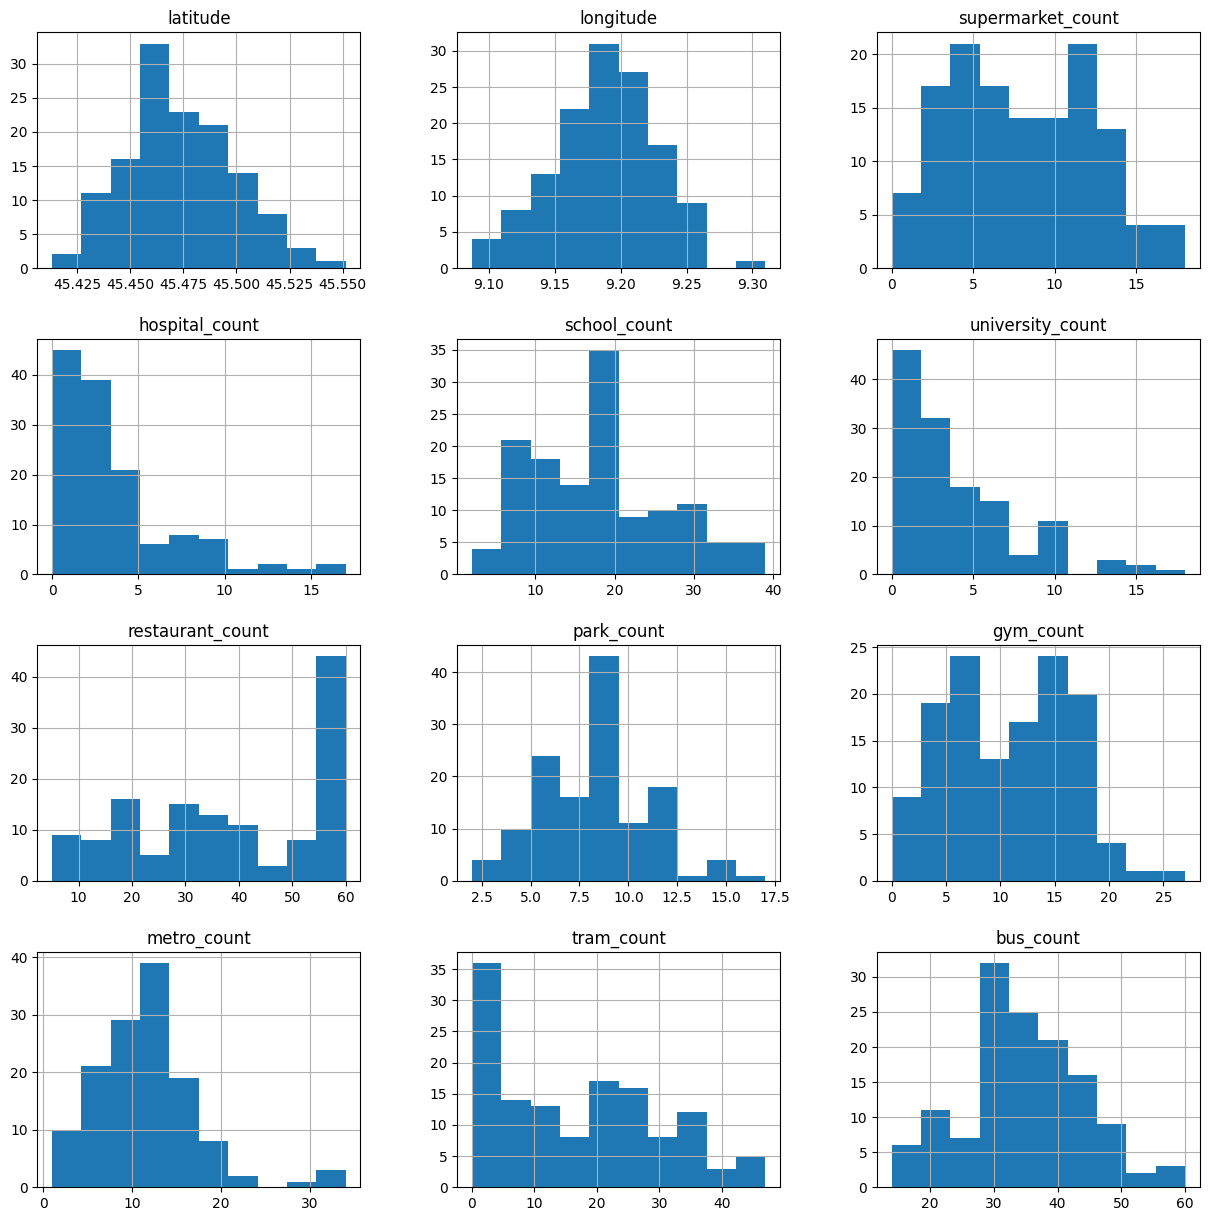

In [149]:
services_df = pd.read_csv('data_with_services/milan_zones_with_service_counts.csv')
services_df = services_df.rename(columns={'supermercato_count_0_5km_radius' : 'supermarket_count',
                                          'ospedale_count_0_5km_radius' : 'hospital_count',
                                          'scuola_count_0_5km_radius' : 'school_count',
                                          'università_count_0_5km_radius' : 'university_count',
                                          'ristorante_count_0_5km_radius' : 'restaurant_count',
                                          'parco_count_0_5km_radius' : 'park_count',
                                          'palestra_count_0_5km_radius' : 'gym_count',
                                          'metro_count_0_5km_radius' : 'metro_count',
                                          'tram_count_0_5km_radius' : 'tram_count',
                                          'bus_count_0_5km_radius' : 'bus_count'})

services_df.hist(figsize=(15, 15))
plt.show()

In [150]:
tr_clean_with_services = tr_clean.merge(
    services_df,
    on='zone', 
    how='left'
)

# Verify the merge
print(f"Original shape of tr_clean: {tr_clean.shape}")
print(f"Shape after adding services: {tr_clean_with_services.shape}")

# Check for any NaN values that might have been introduced by the merge
missing_services = tr_clean_with_services.isna().sum()
print("\nMissing values after merge:")
print(missing_services[missing_services > 0])


te_clean_with_services = te_clean.merge(
    services_df,
    on='zone', 
    how='left'
)
# verify the merge
print(f"\n\nOriginal shape of te_clean: {te_clean.shape}")
print(f"Shape after adding services: {te_clean_with_services.shape}")

missing_services = te_clean_with_services.isna().sum()
print("\nMissing values after merge:")
print(missing_services[missing_services > 0])

Original shape of tr_clean: (4500, 106)
Shape after adding services: (4500, 118)

Missing values after merge:
Series([], dtype: int64)


Original shape of te_clean: (2834, 105)
Shape after adding services: (2834, 117)

Missing values after merge:
Series([], dtype: int64)


## Interaction effects

In [151]:
def add_sqm_x_zone_rank(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds an interaction term: square_meters * zone_rank.
    Assumes 'square_meters' and 'zone_rank' exist and are numeric.
    """
    df_copy = df.copy()
    required_cols = ['square_meters', 'zone_rank']
    if all(col in df_copy.columns for col in required_cols):
        if pd.api.types.is_numeric_dtype(df_copy['square_meters']) and \
           pd.api.types.is_numeric_dtype(df_copy['zone_rank']):
            df_copy['sqm_x_zone_rank'] = df_copy['square_meters'] * df_copy['zone_rank']
            print("Interaction term 'sqm_x_zone_rank' added.")
        else:
            print("Error in 'add_sqm_x_zone_rank': 'square_meters' or 'zone_rank' is not numeric.")
    else:
        print(f"Error in 'add_sqm_x_zone_rank': Missing one or more required columns: {required_cols}")
    return df_copy

def add_sqm_x_condition(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds an interaction term: square_meters * conditions_imputed.
    Assumes 'square_meters' and 'conditions_imputed' exist and are numeric.
    'conditions_imputed' should ideally be a numerical scale (higher = better).
    """
    df_copy = df.copy()
    required_cols = ['square_meters', 'conditions_imputed']
    if all(col in df_copy.columns for col in required_cols):
        if pd.api.types.is_numeric_dtype(df_copy['square_meters']) and \
           pd.api.types.is_numeric_dtype(df_copy['conditions']):
            df_copy['sqm_x_condition'] = df_copy['square_meters'] * df_copy['conditions']
            print("Interaction term 'sqm_x_condition' added.")
        else:
            print("Error in 'add_sqm_x_condition': 'square_meters' or 'conditions_imputed' is not numeric.")
    else:
        print(f"Error in 'add_sqm_x_condition': Missing one or more required columns: {required_cols}")
    return df_copy

def add_floor_x_no_elevator(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds an interaction term: floor * (1 - elevator).
    Assumes 'floor' is numeric and 'elevator' is binary (0 or 1).
    """
    df_copy = df.copy()
    required_cols = ['floor', 'elevator']
    if all(col in df_copy.columns for col in required_cols):
        if pd.api.types.is_numeric_dtype(df_copy['floor']) and \
           pd.api.types.is_numeric_dtype(df_copy['elevator']):
            # Ensure elevator is 0 or 1, or can be interpreted as such
            if df_copy['elevator'].isin([0, 1]).all():
                df_copy['floor_x_no_elevator'] = df_copy['floor'] * (1 - df_copy['elevator'])
                print("Interaction term 'floor_x_no_elevator' added.")
            else:
                print("Error in 'add_floor_x_no_elevator': 'elevator' column should be binary (0 or 1).")
        else:
            print("Error in 'add_floor_x_no_elevator': 'floor' or 'elevator' is not numeric.")
    else:
        print(f"Error in 'add_floor_x_no_elevator': Missing one or more required columns: {required_cols}")
    return df_copy

def add_bedrooms_x_zone_rank(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds an interaction term: bedrooms * zone_rank.
    Assumes 'bedrooms' and 'zone_rank' exist and are numeric.
    """
    df_copy = df.copy()
    required_cols = ['bedrooms', 'zone_rank']
    if all(col in df_copy.columns for col in required_cols):
        if pd.api.types.is_numeric_dtype(df_copy['bedrooms']) and \
           pd.api.types.is_numeric_dtype(df_copy['zone_rank']):
            df_copy['bedrooms_x_zone_rank'] = df_copy['bedrooms'] * df_copy['zone_rank']
            print("Interaction term 'bedrooms_x_zone_rank' added.")
        else:
            print("Error in 'add_bedrooms_x_zone_rank': 'bedrooms' or 'zone_rank' is not numeric.")
    else:
        print(f"Error in 'add_bedrooms_x_zone_rank': Missing one or more required columns: {required_cols}")
    return df_copy

def add_sqm_x_high_efficiency(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds an interaction term: square_meters * is_high_efficiency.
    Assumes 'square_meters' is numeric and 'is_high_efficiency' is binary (0 or 1).
    """
    df_copy = df.copy()
    required_cols = ['square_meters', 'is_high_efficiency']
    if all(col in df_copy.columns for col in required_cols):
        if pd.api.types.is_numeric_dtype(df_copy['square_meters']) and \
           pd.api.types.is_numeric_dtype(df_copy['is_high_efficiency']):
            # Ensure is_high_efficiency is 0 or 1
            if df_copy['is_high_efficiency'].isin([0, 1]).all():
                df_copy['sqm_x_high_efficiency'] = df_copy['square_meters'] * df_copy['is_high_efficiency']
                print("Interaction term 'sqm_x_high_efficiency' added.")
            else:
                print("Error in 'add_sqm_x_high_efficiency': 'is_high_efficiency' column should be binary (0 or 1).")
        else:
            print("Error in 'add_sqm_x_high_efficiency': 'square_meters' or 'is_high_efficiency' is not numeric.")
    else:
        print(f"Error in 'add_sqm_x_high_efficiency': Missing one or more required columns: {required_cols}")
    return df_copy


In [152]:
tr_clean = add_sqm_x_zone_rank(tr_clean)
tr_clean = add_sqm_x_condition(tr_clean)
tr_clean = add_floor_x_no_elevator(tr_clean)
tr_clean = add_bedrooms_x_zone_rank(tr_clean)
tr_clean = add_sqm_x_high_efficiency(tr_clean)

te_clean = add_sqm_x_zone_rank(te_clean)
te_clean = add_sqm_x_condition(te_clean)
te_clean = add_floor_x_no_elevator(te_clean)
te_clean = add_bedrooms_x_zone_rank(te_clean)
te_clean = add_sqm_x_high_efficiency(te_clean)

Interaction term 'sqm_x_zone_rank' added.
Interaction term 'sqm_x_condition' added.
Interaction term 'floor_x_no_elevator' added.
Interaction term 'bedrooms_x_zone_rank' added.
Interaction term 'sqm_x_high_efficiency' added.
Interaction term 'sqm_x_zone_rank' added.
Interaction term 'sqm_x_condition' added.
Interaction term 'floor_x_no_elevator' added.
Interaction term 'bedrooms_x_zone_rank' added.
Interaction term 'sqm_x_high_efficiency' added.


# Export

In [154]:
tr_clean.to_csv('tr_clean.csv', index=False)
te_clean.to_csv('te_clean.csv', index=False)